Goal of this notebook is to apply natural language processing (NLP) on the app names, to predict rating bin.
For inspiration the nlp chapter of the udemy course was used.

In [26]:
import nltk
import os
import pandas as pd
import seaborn as sns
import string
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

In [3]:
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to C:\Users\~LarsSpekscho
[nltk_data]    |     orTrain\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to C:\Users\~LarsSpeks
[nltk_data]    |     choorTrain\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to C:\Users\~LarsSpekscho
[nltk_data]    |     orTrain\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to C:\Users\~LarsSpeksc
[nltk_data]    |     hoorTrain\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to C:\Users\~LarsSpeksc
[nltk_data]    |     hoorTrain\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already 

True

In [4]:
# Data source: https://www.kaggle.com/datasets/gauthamp10/google-playstore-apps
path = os.getcwd() + "/../data/Google-Playstore-Modified.parquet"
df = pd.read_parquet(path, engine='fastparquet')

In [8]:
#Temporarily add back Rating Bin
df['Rating Bin'] = (df[['Moderate', 'Superb', 'Bad App Yo']]==1).idxmax(1)

In [9]:
df.head()

,App Name,App Id,Rating Count,Maximum Installs,Free,Price,Size,Ad Supported,In App Purchases,Name Length,Size Cat,Days Release to Last Update,Moderate,Superb,Bad App Yo,Personal & Social,Entertainment,Development,Rating Bin
0,Ampere Battery Info,com.webserveis.batteryinfo,64,7662,True,0.0,2.9,True,False,19,Known,350,0,1,0,0,1,0,Superb
1,unlimited 4G data prank free app,getfreedata.superfatiza.unlimitedjiodataprank,12,2567,True,0.0,2.5,True,False,32,Known,4,0,0,1,0,1,0,Bad App Yo
2,The Everyday Calendar,com.mozaix.simoneboard,39,702,True,0.0,16.0,False,False,21,Known,0,1,0,0,0,0,1,Moderate
3,Neon 3d Iron Tech Keyboard Theme,com.ikeyboard.theme.neon_3d.iron.tech,820,62433,True,0.0,3.5,True,False,32,Known,381,0,0,1,0,0,1,Bad App Yo
4,Dodge The Cars!,com.MrScratchEnterprises.CarDogeGame,55,329,True,0.0,51.0,False,False,15,Known,0,0,0,1,1,0,0,Bad App Yo


In [41]:
#Next two lines were moved to feature engineering
#df['App Name'] = df['App Name'].apply(str)
#df['Name Name Length'] = df['App Name'].apply(len)
df = df[['App Name', 'Rating Bin', 'Name Length']]

x_train, x_test, y_train, y_test = train_test_split(df[['App Name', 'Name Length']], df['Rating Bin'], test_size=0.1, random_state=123)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=123)

df_train = pd.concat([x_train, y_train], axis=1)
df_val = pd.concat([x_val, y_val], axis=1)
df_test = pd.concat([x_test, y_test], axis=1)

df_train.groupby('Rating Bin').describe()

Name Length                                                   
                 count       mean        std  min   25%   50%   75%   max
Rating Bin                                                               
Bad App Yo    218954.0  22.942463  12.487027  1.0  13.0  20.0  30.0  50.0
Moderate      205467.0  22.321219  12.213647  1.0  13.0  20.0  29.0  50.0
Superb        196831.0  24.316454  12.321888  1.0  14.0  23.0  31.0  50.0

In [33]:
type(y_train)

pandas.core.series.Series

How is the Name Length of app name distributed?

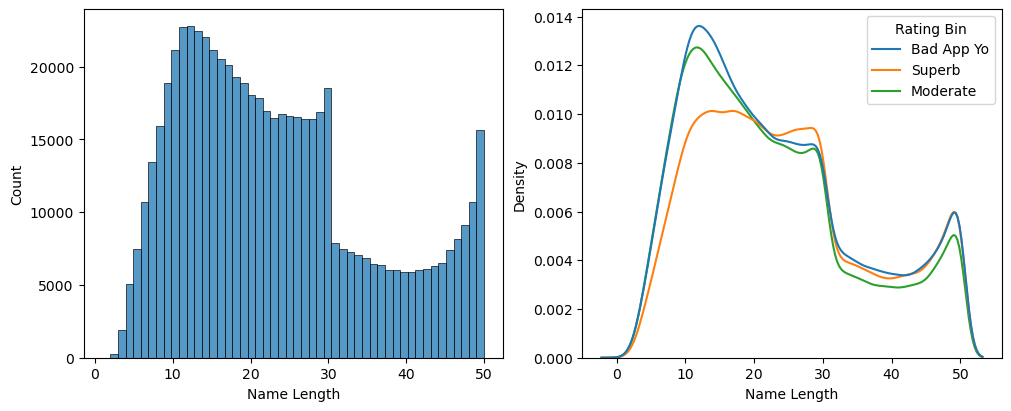

In [43]:
fig, axs = plt.subplots(1,2, figsize=(10, 4), constrained_layout=True)
sns.histplot(x = df_train['Name Length'], bins=50, ax=axs[0])
sns.kdeplot(x = df_train['Name Length'], hue=df_train['Rating Bin'], ax=axs[1])
#From: https://discourse.matplotlib.org/t/how-to-save-subplots-separately/22657/2
fig.savefig(
    "../outputs/figures/Name Length counts all.png",
    # we need a bounding box in inches
    bbox_inches=mtransforms.Bbox(
        # This is in "figure fraction" for the bottom half
        # input in [[xmin, ymin], [xmax, ymax]]
        [[0, 0], [0.5, 1]]
    ).transformed(
        # this take data from figure fraction -> inches
        #    transFigrue goes from figure fraction -> pixels
        #    dpi_scale_trans goes from inches -> pixels
        (fig.transFigure - fig.dpi_scale_trans)
    ),
)
fig.savefig(
    "../outputs/figures/Name Length kde by Rating Bin.png",
    # we need a bounding box in inches
    bbox_inches=mtransforms.Bbox(
        # This is in "figure fraction" for the bottom half
        # input in [[xmin, ymin], [xmax, ymax]]
        [[0.5, 0], [1, 1]]
    ).transformed(
        # this take data from figure fraction -> inches
        #    transFigrue goes from figure fraction -> pixels
        #    dpi_scale_trans goes from inches -> pixels
        (fig.transFigure - fig.dpi_scale_trans)
    ),
)


Is there something off about the longer app names?
Yes, there are many apps with length 30 or 50, because these represent a new and old maximum length set by Google resp.
App names do not appear truncated, suggesting developers are actively trying to fit their name within the limits.

In [50]:
list(df_train[df_train['Name Length'] == 50]['App Name'][:20])

['Speak Hungarian : Learn Hungarian Language Offline',
 'Tech VPN - Free VPN Proxy, Secure fast VPN Privacy',
 'आयुर्वेदीक घरगुती उपाय-डॉ.स्वागत तोडकर,राजीव दीक्ष',
 'Law College and OpenUniversity Entrance Exam Guide',
 'Chiang Mai SmartGuide - Audio Guide & Offline Maps',
 'تعلم الإنجليزية بالإستماع والتكلم-English learning',
 'PhotoLab Pro : Neon Photo Editor, Background erase',
 'Top Ghana Radio Stations -Peace FM, MOGPA, AngelFM',
 'hCue Lite for Doctor| Practice Management Software',
 'Lei Orgânica da Saúde - Leis nº 8080 + 8142 + 7508',
 'Switch Up: Ping Pong  Classic Arcade Games – Retro',
 'IELTS Cue Card:Speaking Practice Material for Exam',
 '強勢股 - 強勢股神器 下一檔飆股在這裡 (強勢股 選股 漲跌 個股分析 台股 股市 股票 看盤 )',
 'Gun Strike - squad battleground | commando mission',
 'INFO TAGIHAN - CEK BIAYA LISTRIK PLN AIR PDAM BPJS',
 'Online Toll Road Payment. Tolling Service by Peasy',
 'Cargo Tractor Trolley Racing Game - New Games 2021',
 'K-Pop Fans – Latest Daily Kpop News, Videos, Drama',
 'Story Sa

In [51]:
print(string.punctuation)
print(stopwords.words('english'))

def text_process(mess):
    """
    1. remove punc
    2. remove stop words
    3. return list of clean text words
    """
    nopunc = ''.join([c for c in mess if c not in string.punctuation])
    clean_mess = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    return clean_mess

df_train['App Name'].head(10).apply(text_process)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only

730958             [Falling, Lights, Minimalist, Challenge]
260838          [MAINGAU, Energie, Elektroauto, Carsharing]
688773                                       [Square, Foot]
704966    [Free, Data, Daily, 50, GB, free, internet, PR...
522196                                       [AppLock, Car]
678700                                          [BushraPay]
501521                                    [クイックリップ（コピペツール）]
553346                   [Candy, Pop, Pop, Sweet, Lollipop]
64071                                      [Junghans, MEGA]
630789                                [Prison, Break, Quiz]
Name: App Name, dtype: object

In [52]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer(analyzer=text_process).fit(df_train['App Name'])

In [53]:
print('Dataframe shape: ', str(df_train.shape))
print('Bow transformer vocabulary length: ', str(len(bow_transformer.vocabulary_)))

Dataframe shape:  (621252, 3)
Bow transformer vocabulary length:  362993


In [54]:
names_bow = bow_transformer.transform(df_train['App Name'])

In [55]:
print('Shape of Sparse Matrix: ', names_bow.shape)
print('Non-zero occurances: ', names_bow.nnz)

sparsity = (100.0 * names_bow.nnz / (names_bow.shape[0] * names_bow.shape[1]))
print('sparsity: {}'.format(sparsity))

Shape of Sparse Matrix:  (621252, 362993)
Non-zero occurances:  2059967
sparsity: 0.0009134698406888889


In [57]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(names_bow)

In [58]:
names_tfidf = tfidf_transformer.transform(names_bow)
print(names_tfidf.shape)

(621252, 362993)


In [59]:
from sklearn.naive_bayes import MultinomialNB
names_model = MultinomialNB().fit(names_tfidf, df_train['Rating Bin'])

In [62]:
train_predictions = names_model.predict(names_tfidf)
#test_predictions = names_model.predict(nam)

from sklearn.metrics import classification_report
print (classification_report(df_train['Rating Bin'], train_predictions))

              precision    recall  f1-score   support

  Bad App Yo       0.74      0.74      0.74    218954
    Moderate       0.69      0.76      0.73    205467
      Superb       0.68      0.61      0.65    196831

    accuracy                           0.71    621252
   macro avg       0.71      0.70      0.70    621252
weighted avg       0.71      0.71      0.71    621252



In [68]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

pipeline.fit(df_train['App Name'], df_train['Rating Bin'])
predictions = pipeline.predict(df_test['App Name'])

print(classification_report(predictions, df_test['Rating Bin']))

              precision    recall  f1-score   support

  Bad App Yo       0.59      0.49      0.53     32659
    Moderate       0.49      0.49      0.49     25158
      Superb       0.33      0.42      0.37     18881

    accuracy                           0.47     76698
   macro avg       0.47      0.47      0.46     76698
weighted avg       0.49      0.47      0.48     76698



In [72]:
print(df_test['Rating Bin'].value_counts()/len(df_test['Rating Bin']))

Bad App Yo    0.354964
Moderate      0.329083
Superb        0.315953
Name: Rating Bin, dtype: float64
